A notebook to visualize the process of querying the SDSS Science Archive and cross matching sources with those for which we have ZTF forced photometry (e.g. all Pan-STARRS1 sources covered by ZTF).

**Workflow Concept:**
* Define the ZTF **Field + CCD + Quadrant + Filter** for which you wish to cross-match sources
* Get the directory where the forced photometry pipeline has saved the *starlist.txt* file for this quadrant + filter.
* Load starlist.txt file and grab the Pan-STARRS1 IDs and coordinates for all objects in the quadrant.
* Submit a Region Query to SDSS using SQL language and Astroquery:
  * Query the targeting catalogs for source metadata and SDSS-V catalog IDs
  * Query the SpecObj catalog to figure out what has actually been observed
* Cross-match SDSS targeting catalogs and spectra with the forced photometry Pan-STARRS1 sources.
* Generate and save a table containing cross-match results for each SDSS MOS target and spectrum.

In [1]:
import io
import os
import sys
import warnings
import requests
import numpy as np
import pandas as pd
import astropy.units as u
import astropy.coordinates as coord
import matplotlib.pyplot as plt

from astropy import wcs
from astropy.io import fits
from astropy.visualization import ZScaleInterval,PercentileInterval
from IPython.display import display, Markdown

sys.path.insert(1, '../')
import sdss_tools as sdss
import ztf_tools as ztf

# Define Field, CCD, Quadrant, and Filter

In [2]:
field = 466
ccd = 4
quad = 3
filters = ['g','r','i']

# Define Directory and Filenames for All Starlist Files (one per *gri* filter) Covering a Quadrant

In [3]:
base_dir = "../data"

starlist_files = []
for filt in filters:
    starlist_file = "{}/ztf_{:06d}_z{}_c{:02d}_q{:1d}_starlist.txt".format(base_dir,field,filt,ccd,quad)
    starlist_files.append(starlist_file)
    
starlist_files

['../data/ztf_000466_zg_c04_q3_starlist.txt',
 '../data/ztf_000466_zr_c04_q3_starlist.txt',
 '../data/ztf_000466_zi_c04_q3_starlist.txt']

# Load in the Starlist File

In [4]:
starlists = []
for f in starlist_files:
    if os.path.isfile(f):
        slist = pd.read_csv(
            f, header=None, 
            names=['psid','ra','dec','x','y'], 
            delim_whitespace=True
        )
        starlists.append(slist)

if len(starlists) > 0:
    starlist = pd.concat(starlists)
    starlist = starlist.drop_duplicates(subset='psid')
    Nstars = len(starlist)
    print(f"\n{Nstars} PS1 sources in quadrant.\n")
    display(Markdown(starlist.head().to_markdown()))
else:
    print('No starlists available')


15745 PS1 sources in quadrant.



|    |        psid |      ra |     dec |     x |     y |
|---:|------------:|--------:|--------:|------:|------:|
|  0 | 1.09991e+17 | 133.856 | 1.66215 |  5.78 | 72.9  |
|  1 | 1.09991e+17 | 133.858 | 1.66606 |  9.64 | 58.84 |
|  2 | 1.10001e+17 | 133.863 | 1.66752 | 27.5  | 53.66 |
|  3 | 1.09991e+17 | 133.863 | 1.66442 | 27.51 | 64.82 |
|  4 | 1.09991e+17 | 133.867 | 1.66504 | 44.32 | 62.66 |

# Find SDSS-V Multi-Object Spectroscopy (MOS) Targets that Cover the ZTF Quadrant
Cell below will perform a rectangular region query that covers the whole sample of coordinates provided, and returns objects from the [SDSS-V MOS (Multi Object Spectroscopy) targeting catalogs](https://www.sdss.org/dr18/targeting/) that fall within that region. Optionally, it will also perform a cross-match between the provided sample coordinates and the returned entries of the SQL query. The returned **idx** parameter provides one index into **starlist** per entry in the returned **res** DataFrame, giving the closest match, while **dsep** provides the on-sky distance, in arcseconds, to the closest match.

In [5]:
# Send query
print('Performing query...',end='')
res, idx, dsep = sdss.MOSquery_from_sample(
    starlist.ra.values,
    starlist.dec.values,
    join_tic=False,
    join_ps1=False,
    #carton='mwm_wd_core',  # You can specificy an SDSS-V carton to only retrieve entries from that carton.
    crossmatch=True,
    verbose=True
)
print('Finished')

# Print out result info
sep_tol = 2.0 # arcseconds
Nmos = len(res)
print(f'{Nmos} entries returned.')
if idx is not None:
    Nmatched = len(res[dsep < sep_tol])
    print(f"{Nmatched} entries matched within {sep_tol:.1f}-arcsec to forced photometry PS1 sources.\n")
display(Markdown(res.head().to_markdown()))

Performing query...

SELECT
main.catalogid as catalogid,
main.ra as ra, 
main.dec as dec,
mcar.carton as carton,
mcar.carton_pk as cartonID,
mcat.lead as parent_catalog,
cad.label as cadence,
inst.label as instrument
FROM mos_carton mcar
JOIN mos_carton_to_target mctt 
  ON mcar.carton_pk = mctt.carton_pk
JOIN mos_cadence cad
  ON cad.pk = mctt.cadence_pk
JOIN mos_instrument inst
  ON inst.pk = mctt.instrument_pk
JOIN mos_target main 
  ON main.target_pk = mctt.target_pk
JOIN mos_catalog mcat
  ON mcat.catalogid = main.catalogid
WHERE ((main.ra between 133.854510 and 134.782295) 
  AND (main.dec between 0.792491 and 1.696896))

Finished
1037 entries returned.
1022 entries matched within 2.0-arcsec to forced photometry PS1 sources.



|    |         catalogid |      ra |      dec | carton                       |   cartonID | parent_catalog   | cadence    | instrument   |
|---:|------------------:|--------:|---------:|:-----------------------------|-----------:|:-----------------|:-----------|:-------------|
|  0 | 27021598102730055 | 133.976 | 1.23797  | openfibertargets_nov2020_6a  |       1057 | tic_v8           | bright_1x1 | BOSS         |
|  1 | 27021598102728903 | 133.976 | 0.853055 | openfibertargets_nov2020_33  |       1022 | tic_v8           | dark_1x1   | BOSS         |
|  2 | 27021598102748016 | 134.549 | 1.57637  | mwm_erosita_stars            |        770 | tic_v8           | bright_1x1 | BOSS         |
|  3 | 27021598102747472 | 134.391 | 1.3374   | openfibertargets_nov2020_35c |       1025 | tic_v8           | bright_1x1 | BOSS         |
|  4 | 27021598102749513 | 134.742 | 1.57737  | openfibertargets_nov2020_46  |       1026 | tic_v8           | bright_1x1 | BOSS         |

# Download ZTF Reference Image

In [6]:
img, hdr, img_wcs = ztf.download_ZTF_refimage(
    field, ccd, quad, 'r')

# Convert coordinates to pixel locations
starlist_radec = [[r,d] for r,d in zip(starlist.ra.values,starlist.dec.values)]
res_radec = [[r,d] for r,d in zip(res.ra.values,res.dec.values)]
starlist_pixcoords = img_wcs.all_world2pix(starlist_radec,0)
res_pixcoords = img_wcs.all_world2pix(res_radec,0)

# Show Image with Matched and Un-Matched SDSS-V MOS Targets

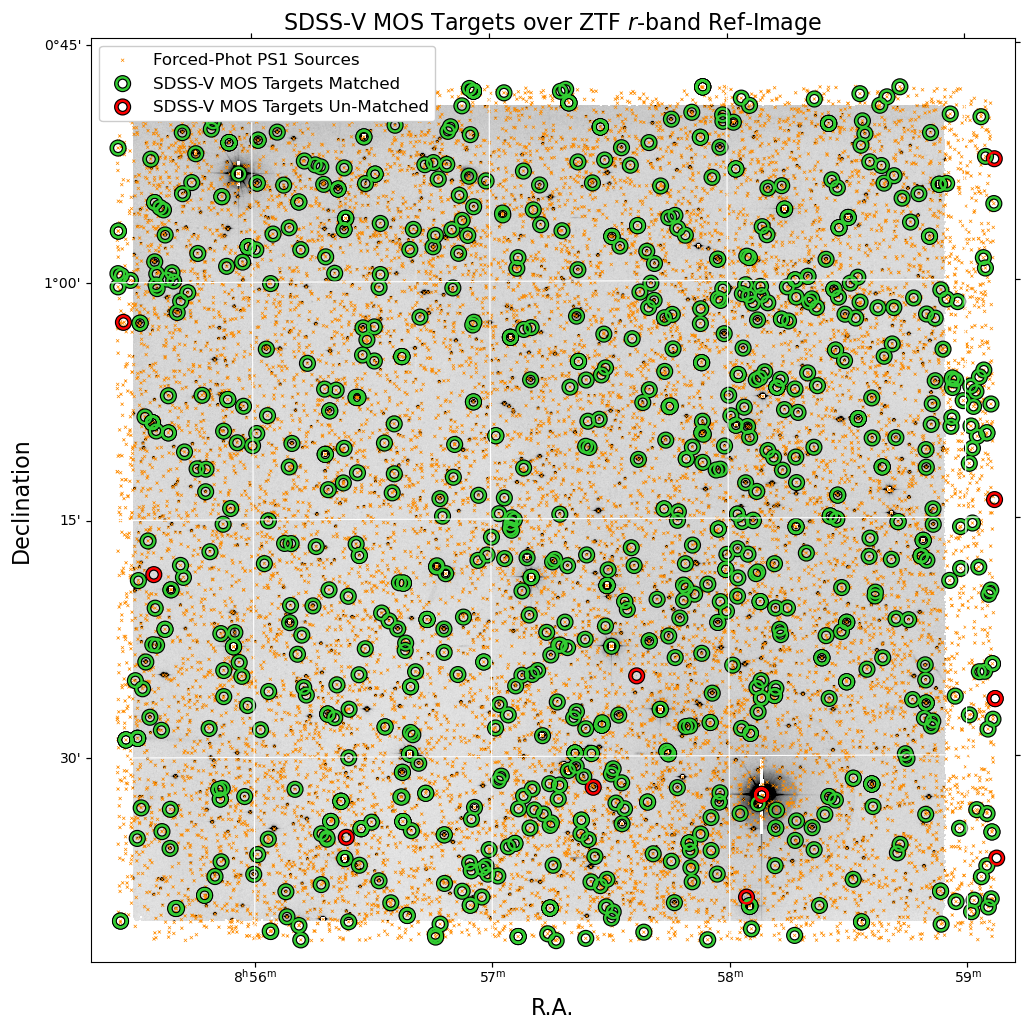

In [7]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111,projection=img_wcs)

# For image visualization
ZS = ZScaleInterval(
    n_samples=10000, contrast=0.15, max_reject=0.5, 
    min_npixels=5, krej=2.5, max_iterations=5
)
vmin,vmax = ZS.get_limits(img)


ax.imshow(
    img, cmap='Greys',
    vmin=vmin,vmax=vmax
)
l1 = ax.scatter(
    starlist_pixcoords[:,0],
    starlist_pixcoords[:,1],
    marker='x', s=5, fc='None',ec='darkorange',lw=0.5
)
l3a = ax.scatter(
    res_pixcoords[:,0],
    res_pixcoords[:,1],
    marker='o', s=80, fc='None',ec='k',lw=3.4
)
l3b = ax.scatter(
    res_pixcoords[:,0][dsep<sep_tol],
    res_pixcoords[:,1][dsep<sep_tol],
    marker='o', s=80, fc='None',ec='limegreen',lw=1.7
)
l3c = ax.scatter(
    res_pixcoords[:,0][dsep>sep_tol],
    res_pixcoords[:,1][dsep>sep_tol],
    marker='o', s=80, fc='None',ec='r',lw=1.7
)
ax.legend(
    [l1, (l3a,l3b), (l3a,l3c)],
    ['Forced-Phot PS1 Sources','SDSS-V MOS Targets Matched','SDSS-V MOS Targets Un-Matched'],
    fontsize=12, framealpha=1.0, loc='upper left'
)

ax.set_title('SDSS-V MOS Targets over ZTF $r$-band Ref-Image',fontsize=16)
ax.set_xlabel('R.A.',fontsize=16)
ax.set_ylabel('Declination',fontsize=16)
ax.set_xlim(-100,3400)
ax.set_ylim(ax.get_xlim())
ax.grid(ls='-',color='w')

# Find Objects with Spectra from DR17 or DR18
The cell below performs a query into the SpecObj (DR17) and spAll (DR18) tables to get a list of all publicly available spectra that cover the defined region. As before, a crossmatch is also performed to find the closest Pan-STARRS1 forced photometry sources to each spectrum. The closest match is added into the table returned by the SQL query, and the table also uncludes URLs that can be used to download the spectrum from the [SDSS science archive](https://data.sdss.org/sas/).

In [8]:
print('Performing Spectral query...',end='')
spec, idx_spec, dsep_spec = sdss.SPECquery_from_sample(
    starlist.ra.values,
    starlist.dec.values,
    data_release='all',
    crossmatch=True,
    verbose=True
)
print('Finished')

if spec is None:
    print('No Entries Returned!')
    Nspec_dr17 = 0
    Nspec_dr18 = 0
else:
    Nspec_dr17 = len(spec[spec.spec_dr==17])
    Nspec_dr18 = len(spec[spec.spec_dr==18])
    Nspec = Nspec_dr17 + Nspec_dr18

    # Add crossmatch results to dataframe and sort table to group
    # any entries with the same PS1-ID match together
    spec['ps1_sep'] = dsep_spec
    spec['nearest_psid'] = starlist['psid'].values[idx_spec]
    spec['psid_count'] = spec.groupby('nearest_psid')['nearest_psid'].transform('count')
    spec.sort_values(
        by=['psid_count','nearest_psid','mjd'], 
        ascending=[False,True,True], 
        inplace=True, ignore_index=True
    )
    
    print(f'\n{Nspec_dr17:5d} DR17 Entries Returned')
    print(f'{Nspec_dr18:5d} DR18 Entries Returned\n')

    # Get number of close matches to PS1 sources
    sep_tol = 2.0
    Nspec_matched = len(spec[dsep_spec<sep_tol])
    Nps1_matched = len(spec[dsep_spec<sep_tol].nearest_psid.unique())
    print(f"{Nspec_matched} out of {Nspec} SDSS spectra matched to {Nps1_matched} Unique PS1 forced-photometry sources.\n")
    display(Markdown(spec.head().to_markdown()))
    
    # Convert coords to pixels
    ra = spec.ra.values
    dec = spec.dec.values
    spec_radec = [[r,d] for r,d in zip(ra,dec)]
    spec_pixcoords = img_wcs.all_world2pix(spec_radec,0)

Performing Spectral query...

DR-17:

SELECT
main.specobjid,
main.ra,
main.dec,
main.programname,
main.survey,
main.sourcetype as objtype,
main.class,
main.subclass,
main.plate,
main.mjd,
main.fiberid
FROM SpecObj main
WHERE ((main.ra between 133.854510 and 134.782295) 
  AND (main.dec between 0.792491 and 1.696896))



DR-18:

SELECT
main.specobjid,
main.plug_ra as ra,
main.plug_dec as dec,
main.programname,
main.survey,
main.objtype,
main.class,
main.subclass,
main.plate,
main.mjd,
main.fiberid,
main.healpix_dir
FROM spAll main
WHERE ((main.plug_ra between 133.854510 and 134.782295) 
  AND (main.plug_dec between 0.792491 and 1.696896))

Finished

  419 DR17 Entries Returned
  224 DR18 Entries Returned

568 out of 643 SDSS spectra matched to 509 Unique PS1 forced-photometry sources.



|    |   specobjid |      ra |     dec | programname   | survey   | objtype          | class   | subclass       |   plate |   mjd |   fiberid |   spec_dr | spec_url                                                                                                             |   ps1_sep |       nearest_psid |   psid_count |
|---:|------------:|--------:|--------:|:--------------|:---------|:-----------------|:--------|:---------------|--------:|------:|----------:|----------:|:---------------------------------------------------------------------------------------------------------------------|----------:|-------------------:|-------------:|
|  0 | 5.28183e+17 | 134.776 | 1.32682 | legacy        | sdss     | HOT_STD          | STAR    | WD             |     469 | 51913 |       493 |        17 | https://data.sdss.org/sas/dr17/sdss/spectro/redux/26/spectra/0469/spec-0469-51913-0493.fits                          | 0.206878  | 109591347759552600 |            4 |
|  1 | 1.70765e+19 | 134.776 | 1.32676 | eFEDS2        | bhm-mwm  | QSO              | STAR    | WDcooler       |   15167 | 59252 |        23 |        18 | https://dr18.sdss.org/sas/dr18/spectro/boss/redux/v6_0_4/spectra/full/15167p/59252/spec-15167-59252-04545189527.fits | 0.0499974 | 109591347759552600 |            4 |
|  2 | 1.70789e+19 | 134.776 | 1.32676 | eFEDS2        | bhm-mwm  | QSO              | STAR    | O8/O9 (167771) |   15169 | 59257 |       421 |        18 | https://dr18.sdss.org/sas/dr18/spectro/boss/redux/v6_0_4/spectra/full/15169p/59257/spec-15169-59257-04545189527.fits | 0.0499974 | 109591347759552600 |            4 |
|  3 | 1.70789e+19 | 134.776 | 1.32676 | eFEDS2        | bhm-mwm  | QSO              | STAR    | O8/O9 (167771) |   15169 | 59313 |       463 |        18 | https://dr18.sdss.org/sas/dr18/spectro/boss/redux/v6_0_4/spectra/full/15169p/59313/spec-15169-59313-04545189527.fits | 0.0499974 | 109591347759552600 |            4 |
|  4 | 5.28092e+17 | 134.702 | 0.90953 | legacy        | sdss     | SPECTROPHOTO_STD | STAR    | F5             |     469 | 51913 |       164 |        17 | https://data.sdss.org/sas/dr17/sdss/spectro/redux/26/spectra/0469/spec-0469-51913-0164.fits                          | 0.324324  | 109091347018011804 |            3 |

# Show Image with Spectra Matched to PS1 Forced Photometry Targets

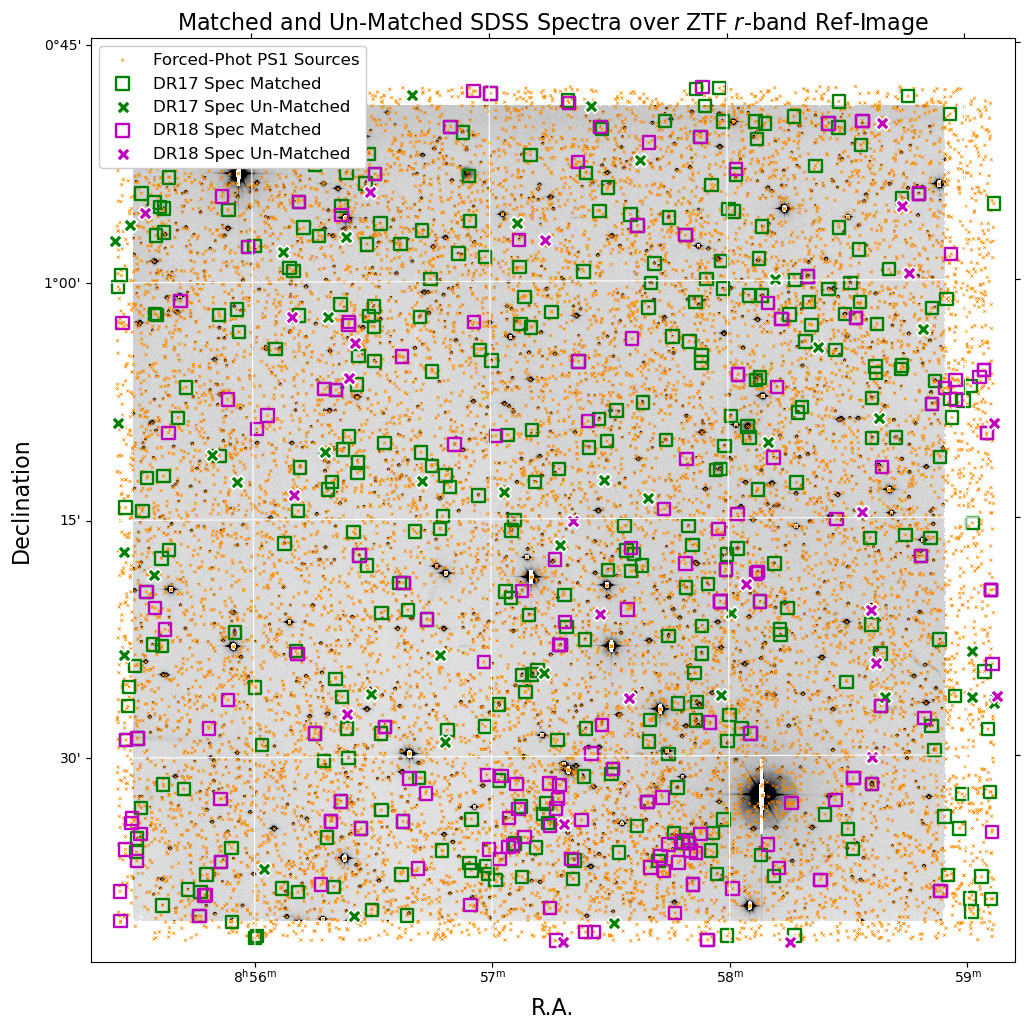

In [9]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111,projection=img_wcs)

vmin,vmax = ZS.get_limits(img)

ax.imshow(
    img, cmap='Greys',
    vmin=vmin,vmax=vmax
)
l1 = ax.scatter(
    starlist_pixcoords[:,0],
    starlist_pixcoords[:,1],
    marker='x', s=5, fc='None',ec='darkorange',lw=0.5
)
legend_handles = [l1]
legend_labels = ['Forced-Phot PS1 Sources']

if Nspec_dr17 > 0:
    
    l2a = ax.scatter(
        spec_pixcoords[:,0][(spec.ps1_sep<sep_tol) & (spec.spec_dr==17)],
        spec_pixcoords[:,1][(spec.ps1_sep<sep_tol) & (spec.spec_dr==17)],
        marker='s', s=80, fc='None',ec='g',lw=1.7
    )
    l2b = ax.scatter(
        spec_pixcoords[:,0][(spec.ps1_sep>sep_tol) & (spec.spec_dr==17)],
        spec_pixcoords[:,1][(spec.ps1_sep>sep_tol) & (spec.spec_dr==17)],
        marker='X', s=100, fc='g',ec='w',lw=1.2
    )
    legend_handles += [l2a, l2b]
    legend_labels += ['DR17 Spec Matched', 'DR17 Spec Un-Matched']


if Nspec_dr18 > 0:
    
    l3a = ax.scatter(
        spec_pixcoords[:,0][(spec.ps1_sep<sep_tol) & (spec.spec_dr==18)],
        spec_pixcoords[:,1][(spec.ps1_sep<sep_tol) & (spec.spec_dr==18)],
        marker='s', s=80, fc='None',ec='m',lw=1.7
    )
    l3b = ax.scatter(
        spec_pixcoords[:,0][(spec.ps1_sep>sep_tol) & (spec.spec_dr==18)],
        spec_pixcoords[:,1][(spec.ps1_sep>sep_tol) & (spec.spec_dr==18)],
        marker='X', s=100, fc='m',ec='w',lw=1.2
    )
    legend_handles += [l3a, l3b]
    legend_labels += ['DR18 Spec Matched', 'DR18 Spec Un-Matched']

    
ax.legend(
    legend_handles,
    legend_labels,
    fontsize=12, framealpha=1.0, loc='upper left'
)

ax.set_title('Matched and Un-Matched SDSS Spectra over ZTF $r$-band Ref-Image',fontsize=16)
ax.set_xlabel('R.A.',fontsize=16)
ax.set_ylabel('Declination',fontsize=16)
ax.set_xlim(-100,3400)
ax.set_ylim(ax.get_xlim())
ax.grid(ls='-',color='w')

# Cross Match SDSS Spectra with MOS Targets
Cell below does one last cross match to determine if any of the SDSS-V MOS targets already have publicly available spectra from data releaes 18 or below. Two more columns are added to the table indicating the SDSS-V catalogid of the closest match, and its on-sky separation from the location of the spectrum.

In [10]:
mos_coords = coord.SkyCoord(
    ra = res.ra.values*u.deg,
    dec = res.dec.values*u.deg,
    frame='icrs'
)
spec_coords = coord.SkyCoord(
    ra = spec.ra.values*u.deg,
    dec = spec.dec.values*u.deg,
    frame='icrs'
)

sep_tol = 2.0
idx_mos, dsep_mos, _ = spec_coords.match_to_catalog_sky(mos_coords)
dsep_mos = dsep_mos.arcsec
spec['mos_sep'] = dsep_mos
spec['nearest_mos_catalogid'] = res['catalogid'].values[idx_mos]

Nmos_matched = len(idx_mos[dsep_mos < sep_tol])
print(f"\n{Nmos_matched} MOS targets matched with spectra within {sep_tol:.1f}-arcsec.\n")
display(Markdown(spec.head().to_markdown()))


301 MOS targets matched with spectra within 2.0-arcsec.



|    |   specobjid |      ra |     dec | programname   | survey   | objtype          | class   | subclass       |   plate |   mjd |   fiberid |   spec_dr | spec_url                                                                                                             |   ps1_sep |       nearest_psid |   psid_count |   mos_sep |   nearest_mos_catalogid |
|---:|------------:|--------:|--------:|:--------------|:---------|:-----------------|:--------|:---------------|--------:|------:|----------:|----------:|:---------------------------------------------------------------------------------------------------------------------|----------:|-------------------:|-------------:|----------:|------------------------:|
|  0 | 5.28183e+17 | 134.776 | 1.32682 | legacy        | sdss     | HOT_STD          | STAR    | WD             |     469 | 51913 |       493 |        17 | https://data.sdss.org/sas/dr17/sdss/spectro/redux/26/spectra/0469/spec-0469-51913-0493.fits                          | 0.206878  | 109591347759552600 |            4 | 0.219471  |       27021598102749535 |
|  1 | 1.70765e+19 | 134.776 | 1.32676 | eFEDS2        | bhm-mwm  | QSO              | STAR    | WDcooler       |   15167 | 59252 |        23 |        18 | https://dr18.sdss.org/sas/dr18/spectro/boss/redux/v6_0_4/spectra/full/15167p/59252/spec-15167-59252-04545189527.fits | 0.0499974 | 109591347759552600 |            4 | 0.0346559 |       27021598102749535 |
|  2 | 1.70789e+19 | 134.776 | 1.32676 | eFEDS2        | bhm-mwm  | QSO              | STAR    | O8/O9 (167771) |   15169 | 59257 |       421 |        18 | https://dr18.sdss.org/sas/dr18/spectro/boss/redux/v6_0_4/spectra/full/15169p/59257/spec-15169-59257-04545189527.fits | 0.0499974 | 109591347759552600 |            4 | 0.0346559 |       27021598102749535 |
|  3 | 1.70789e+19 | 134.776 | 1.32676 | eFEDS2        | bhm-mwm  | QSO              | STAR    | O8/O9 (167771) |   15169 | 59313 |       463 |        18 | https://dr18.sdss.org/sas/dr18/spectro/boss/redux/v6_0_4/spectra/full/15169p/59313/spec-15169-59313-04545189527.fits | 0.0499974 | 109591347759552600 |            4 | 0.0346559 |       27021598102749535 |
|  4 | 5.28092e+17 | 134.702 | 0.90953 | legacy        | sdss     | SPECTROPHOTO_STD | STAR    | F5             |     469 | 51913 |       164 |        17 | https://data.sdss.org/sas/dr17/sdss/spectro/redux/26/spectra/0469/spec-0469-51913-0164.fits                          | 0.324324  | 109091347018011804 |            3 | 0.343829  |       27021598102736831 |

# Save Summary Table of Matched Spectra
The above table is currently what I consider to be the final data product that will be of use to this group. I will generate one table like this per ZTF quadrant and then merge them all together into a single file. If you feel like there is anything missing, please let me know and I can add it in. Below is just a simple example of how I'm saving individual quadrant tables to file.

In [11]:
save_dir = "../data/"
filename = f"{save_dir}matched_spec_dr18_{field:06d}_c{ccd:02d}_q{quad:1d}.csv"

spec.to_csv(filename, index=False)

# Fetch and Plot a Few Spectra for fun
The sdss_tools package has a convenience function for retrieveing the spectrum of a source given the URL to download it from. Returned data is a dictionary with the following entries:
* **wavelength**: Wavelength in angstroms
* **flux**: Flux density in 10^16 erg/s/cm^2/A
* **e_flux**: Flux density uncertainty in same units as **flux**
* **fsky**: Sky flux in same units as **flux**
* **header**: The full header, in case you desire extra metadata.

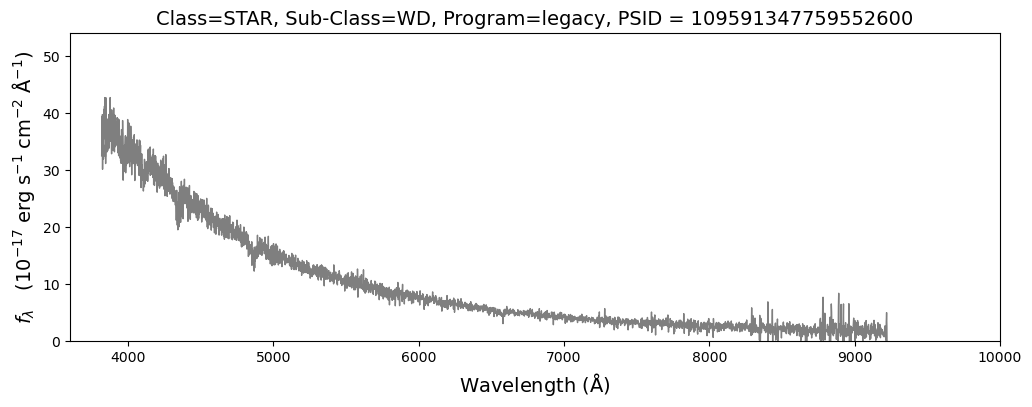

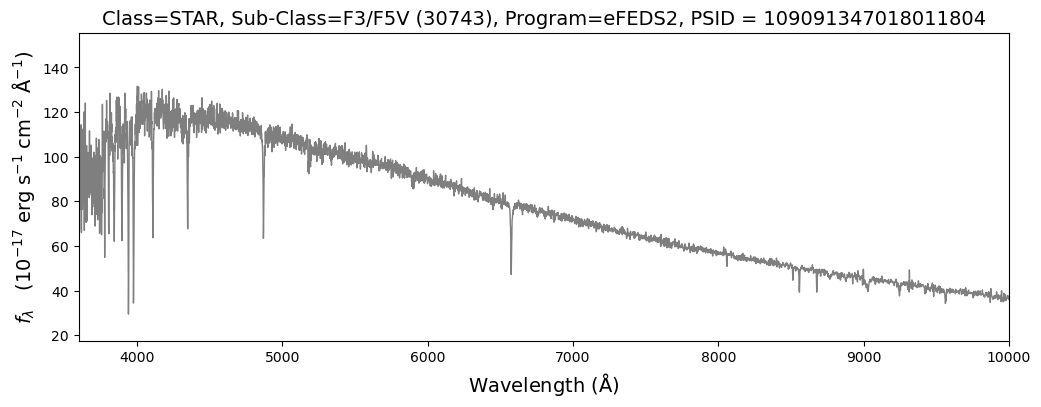

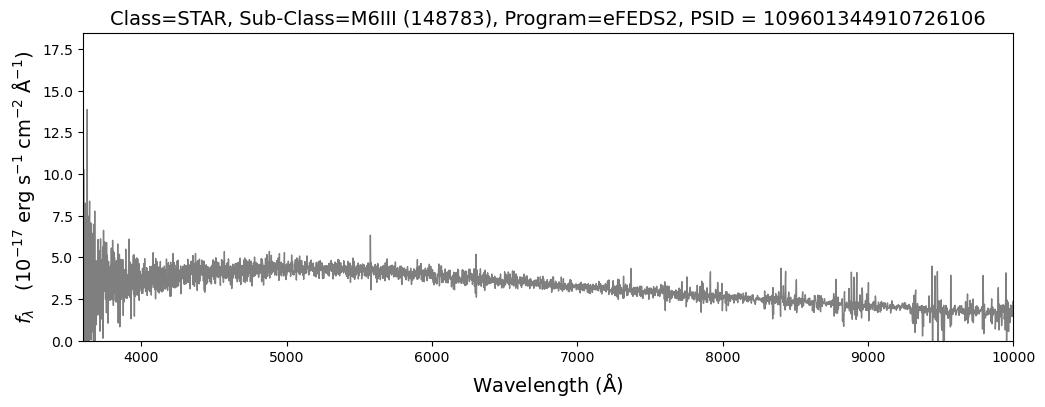

In [13]:
for obj_index in range(3):

    obj_index = obj_index*5
    obj_url = spec.spec_url.iloc[obj_index]
    spec_data = sdss.get_SDSS_spectrum(obj_url)
    
    if spec_data is not None:
    
        # Get object metadata
        obj_class = spec['class'].iloc[obj_index]
        obj_subclass = spec['subclass'].iloc[obj_index]
        obj_program = spec['programname'].iloc[obj_index]
        if spec.ps1_sep.iloc[obj_index] < sep_tol:
            obj_psid = spec.nearest_psid.iloc[obj_index]
            pmatch = f"PSID = {obj_psid}"
        else:
            pmatch = f'No PS1 Match within {sep_tol:.1f}"'
        
        
    
        fig = plt.figure(figsize=(12,4))
        ax = fig.add_subplot(111)
        
        ax.plot(
            spec_data['wavelength'], 
            spec_data['flux'], 
            ls='-',lw=1,c='C7'
        )
    
        ptitle = f"Class={obj_class}, Sub-Class={obj_subclass}, Program={obj_program}, {pmatch}"
        ax.set_title(ptitle, fontsize=14)
        ax.set_xlabel('Wavelength ($\mathrm{\AA}$)',fontsize=14)
        ax.set_ylabel('$f_{\lambda}$   ($10^{-17}$ $\mathrm{erg\;s^{-1}\;cm^{-2}\;\AA^{-1}}$)',fontsize=14)
        
        # Set XY limits
        PI = PercentileInterval(99.9)
        flux_limits = PI.get_limits(spec_data['flux'])
        flux_range = flux_limits[1] - flux_limits[0]
        if flux_limits[0] < 0:
            ylow = 0.0
        else:
            ylow = flux_limits[0]-0.10*flux_range
        yupp = flux_limits[1]+0.25*flux_range
        ax.set_xlim(3600,10000)
        ax.set_ylim(ylow, yupp)

        plt.show()
        plt.close()
    else:
        print('No spectral data returned.')